In [1]:
import sys

sys.path.insert(0, '../')
import utils.common as cm
import utils.bootcampviztools as viz
import gdown

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
import seaborn as sns
sns.set_theme(style = "whitegrid", palette = "muted", context = "notebook")
import re

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

## Introducción

Debido a los cambios actuales en el mercado automovilístico en España, este proyecto trata de establecer el precio de coches de segunda mano según sus características y estado de desgaste, proporcionando una guía sobre la que estimar el coste.

Los datos han sido obtenidos de DataMarket.

In [5]:
url = cm.DATA_PATH
output = "data.csv"
gdown.download(url, output, quiet = False)

df = pd.read_csv("data.csv")

Downloading...
From (original): https://drive.google.com/uc?id=1NtUt42nZ766HduQfyAxls1pX6deqtVh2
From (redirected): https://drive.google.com/uc?id=1NtUt42nZ766HduQfyAxls1pX6deqtVh2&confirm=t&uuid=5718f011-1156-4145-b610-300c72c35304
To: c:\Users\mpuch\Desktop\Portfolio_M_Puchades\ML_car_prices\src\results_notebook\data.csv
100%|██████████| 122M/122M [00:02<00:00, 54.8MB/s] 


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   vehicle_type            100000 non-null  object 
 1   make                    100000 non-null  object 
 2   model                   100000 non-null  object 
 3   version                 99842 non-null   object 
 4   fuel                    96810 non-null   object 
 5   year                    100000 non-null  int64  
 6   kms                     99189 non-null   float64
 7   power                   99709 non-null   float64
 8   doors                   0 non-null       float64
 9   shift                   98982 non-null   object 
 10  color                   0 non-null       float64
 11  photos                  100000 non-null  int64  
 12  description             55810 non-null   object 
 13  price                   100000 non-null  int64  
 14  currency             

## Descripción de las variables
<table>
<tr>
    <th>Nombre de columna</th>
    <th>Tipo de variable</th>
    <th>Descripción</th>
    <th>Comentarios</th>
</tr>
<tr>
    <td>vehicle_type</td>
    <td>Categórica</td>
    <td>Tipo de vehículo</td>
    <td>Todos los vehículos son coches (columna para eliminar)</td>
</tr>
<tr>
    <td>make</td>
    <td>Categórica</td>
    <td>Marca del vehículo</td>
    <td></td>
</tr>
<tr>
    <td>model</td>
    <td>Categórica</td>
    <td>Modelo del vehículo</td>
    <td>Habrá que ver si los nombres están bien escritos o hay valores repetidos</td>
</tr>
<tr>
    <td>version</td>
    <td>Texto/categórica</td>
    <td>Versión del modelo concreto de coche</td>
    <td>Habrá que valorar si se puede sacar información interesante de esa columna</td>
</tr>
<tr>
    <td>fuel</td>
    <td>Categórica</td>
    <td>Tipo de combustible que usa el vehículo</td>
    <td></td>
</tr>
<tr>
    <td>year</td>
    <td>Numérica</td>
    <td>Año al que pertenece el vehículo (fabricación)</td>
    <td></td>
</tr>
<tr>
    <td>kms</td>
    <td>Numérica</td>
    <td>Kilometraje realizado por el vehículo</td>
    <td></td>
</tr>
<tr>
    <td>power</td>
    <td>Numérica</td>
    <td>Potencia en caballos que tiene el coche</td>
    <td></td>
</tr>
<tr>
    <td>doors</td>
    <td>Numérica</td>
    <td>Número de puertas</td>
    <td>Tiene un 100% de missings, en principio se eliminará (a no ser que en otra columna encontremos el número de puertas)</td>
</tr>
<tr>
    <td>shift</td>
    <td>Binaria</td>
    <td>Tipo de cambio</td>
    <td>Manual; Automatic</td>
</tr>
<tr>
    <td>color</td>
    <td>Numérica</td>
    <td>Color del coche</td>
    <td>Tiene un 100% de missings, en principio se eliminará esta columna</td>
</tr>
<tr>
    <td>photos</td>
    <td>Numérica</td>
    <td>Número de fotos subidas al anuncio del coche</td>
    <td></td>
</tr>
<tr>
    <td>description</td>
    <td>Texto</td>
    <td>Anuncio del coche</td>
    <td>Probablemente eliminemos esta columna (44% de missings)</td>
</tr>
<tr>
    <td>price</td>
    <td>Numérica</td>
    <td>Precio del coche</td>
    <td>Esta columna será nuestro TARGET</td>
</tr>
<tr>
    <td>currency</td>
    <td>Categórica</td>
    <td>Tipo de moneda en la que se encuentra el precio</td>
    <td>Columna a eliminar, ya que tiene un único valor: €</td>
</tr>
<tr>
    <td>location</td>
    <td>Categórica</td>
    <td>Población en la que se vende el vehículo</td>
    <td>Valoraremos si utilizarla o no (tenemos código postal)</td>
</tr>
<tr>
    <td>publish_date</td>
    <td>Datetime</td>
    <td>Fecha de publicación del anuncio</td>
    <td></td>
</tr>
<tr>
    <td>update_date</td>
    <td>Datetime</td>
    <td>Fecha de actualización del anuncio</td>
    <td></td>
</tr>
<tr>
    <td>dealer_name</td>
    <td>Texto</td>
    <td>Nombre del vendedor particular o empresa</td>
    <td></td>
</tr>
<tr>
    <td>dealer_description</td>
    <td>Texto</td>
    <td>Descripción de la empresa de venta</td>
    <td>Probablemente eliminemos esta columna</td>
</tr>
<tr>
    <td>dealer_address</td>
    <td>Texto</td>
    <td>Dirección donde se encuentra la empresa que vende el vehículo</td>
    <td>Probablemente eliminemos esta columna</td>
</tr>
<tr>
    <td>dealer_zip_code</td>
    <td>Numérica</td>
    <td>Código postal del vendedor</td>
    <td></td>
</tr>
<tr>
    <td>dealer_city</td>
    <td>Texto</td>
    <td>Ciudad en la que se encuentra el vendedor</td>
    <td></td>
</tr>
<tr>
    <td>dealer_country_code</td>
    <td>Categórica</td>
    <td>Código escrito del nombre del país</td>
    <td>Esta columna tiene un único valor, la eliminaremos</td>
</tr>
<tr>
    <td>dealer_is_professional</td>
    <td>Binaria</td>
    <td>Indica si el vendedor es una empresa profesional que se dedica a ello o un particular</td>
    <td>Eliminaremos esta columna, ya que tiene un valor único: True</td>
</tr>
<tr>
    <td>dealer_website</td>
    <td>Texto</td>
    <td>Link a la página web de la empresa que vende el vehículo</td>
    <td>Esta columna la eliminaremos</td>
</tr>
<tr>
    <td>dealer_registered_at</td>
    <td>Datetime</td>
    <td>Fecha en la que el vendedor se registró en la plataforma</td>
    <td>Probablemente eliminaremos esta columna</td>
</tr>
<tr>
    <td>date</td>
    <td>Datetime</td>
    <td>Fecha en la que se extrajo la información</td>
    <td>Valoraremos si eliminar esta columna o solo utilizar una fecha concreta</td>
</tr>
</table>

In [7]:
total_cols = list(df.columns)

In [8]:
cm.data_report(df)

,DATA_TYPE,MISSINGS (%),UNIQUE_VALUES,CARDIN (%)
COL_N,,,,
vehicle_type,object,0.00,1,0.00
make,object,0.00,66,0.07
model,object,0.00,748,0.75
version,object,0.16,8658,8.66
fuel,object,3.19,4,0.00
year,int64,0.00,43,0.04
kms,float64,0.81,6643,6.64
power,float64,0.29,349,0.35
doors,float64,100.00,0,0.00


In [9]:
df.sample(5)

,vehicle_type,make,model,version,fuel,year,kms,power,doors,shift,...,dealer_name,dealer_description,dealer_address,dealer_zip_code,dealer_city,dealer_country_code,dealer_is_professional,dealer_website,dealer_registered_at,date
79582,car,Nissan,Qashqai,2.0G 140 Tekna 4x2 5p,Gasolina,2008,NaN,140.0,NaN,manual,...,Alberto R.,ESPECIALISTAS EN VEHICULOS NACIONALES Y DE IMP...,"Lartzabal auzoa, Lartzabal, Errenteria, Donost...",20100.0,Errenteria,ES,True,NaN,2015-09-02,2023-01-26
156,car,Opel,Zafira Tourer,1.4 T S/S 103kW (140CV) Family,Gasolina,2018,84756.0,140.0,NaN,manual,...,FLEXICAR M.,"Para Comprar o Vender tu coche, Primero en FLE...","Jardín General Palarea, Calle Sierra de Peñarr...",30005.0,Murcia,ES,True,www.flexicar.es,2021-05-14,2023-02-07
68370,car,Nissan,X-Trail,dCi 130 N-Connecta 96 kW (130 CV),Diésel,2016,110878.0,130.0,NaN,manual,...,OCASION P.,OcasionPlus Paterna fue el primer centro que i...,"Ajuntament, Plaça de l'Enginyer Castells, Albo...",46980.0,Paterna,ES,True,www.ocasionplus.com,2019-10-31,2023-02-06
58986,car,Peugeot,108,1.0 VTi Active ETG5,Gasolina,2016,4959.0,70.0,NaN,automatic,...,AUTOHERO SESEÑA M.,Concesionario con proceso de compra online con...,"Dña. Berenguela, Paseo de Argentina, Jerónimos...",28014.0,Madrid,ES,True,https://www.autohero.com/es/,2018-02-07,2023-01-26
975,car,Opel,Vivaro,1.6 CDTI S/S 107kW L1 2.7t Life-7,Diésel,2018,83477.0,145.0,NaN,manual,...,FLEXICAR M.,"Para Comprar o Vender tu coche, Primero en FLE...","Mercado de El Carmen, 1, Calle Senador Francis...",29005.0,Málaga,ES,True,www.flexicar.es,2017-02-28,2023-02-06


#### Creamos una copia de seguridad

In [10]:
df_copy = df.copy()

## División en train y test

In [11]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

In [12]:
print('Las dimensiones de train son:', train.shape)
print('Las dimensiones de test son:', test.shape)

Las dimensiones de train son: (80000, 28)
Las dimensiones de test son: (20000, 28)


## Análisis del target

In [13]:
target = 'price'

(2,)


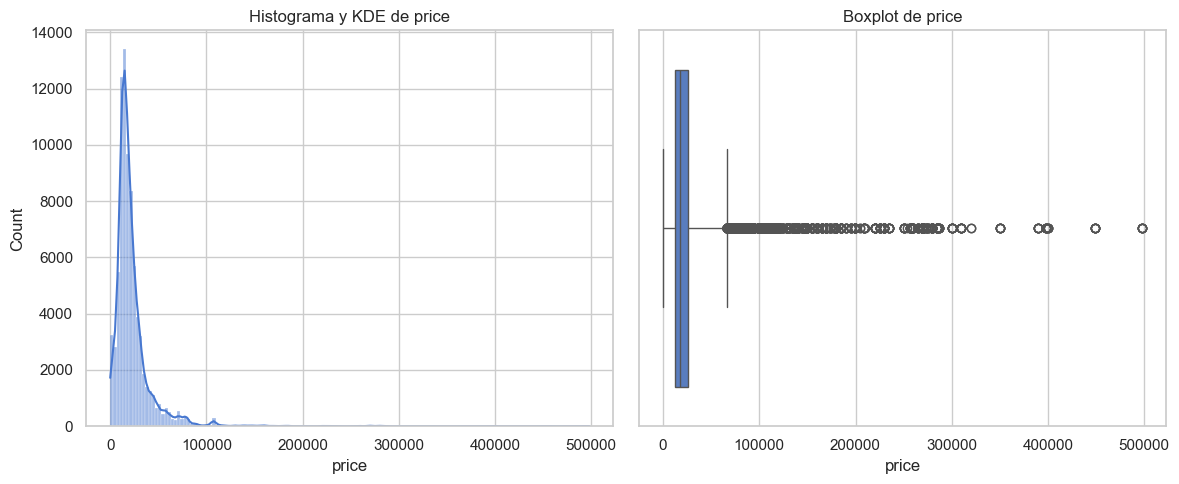

In [14]:
viz.plot_distribution_combined_graphs(train, [target], whisker_width = 3, bins = 150)

In [15]:
train[target].describe()

count     80000.000000
mean      22844.601438
std       23158.585868
min           0.000000
25%       12490.000000
50%       17450.000000
75%       25875.000000
max      498000.000000
Name: price, dtype: float64

Se puede apreciar que el target tiene una distribución en larga cola, lo cual tendremos que tener en cuenta a la hora de modelar. También encontramos grandes outliers, que veremos qué hacer con ellos.

Nos llama la atención que hay coches que tienen un precio de 0, lo cual es un error o un anuncio falso. Por ello, procedemos a eliminar todas las filas que tengan un precio menor de 100€.

In [20]:
train.drop(index = (train.loc[train[target] < 2000].index), inplace = True)

In [21]:
test.drop(index = (train.loc[train[target] < 2000].index), inplace = True)

Vamos a ver cómo cambia la distribución del target al aplicar alguna transformación, vamos a intentar que su distribución sea lo más normal posible.

Con una transformación logarítmica:


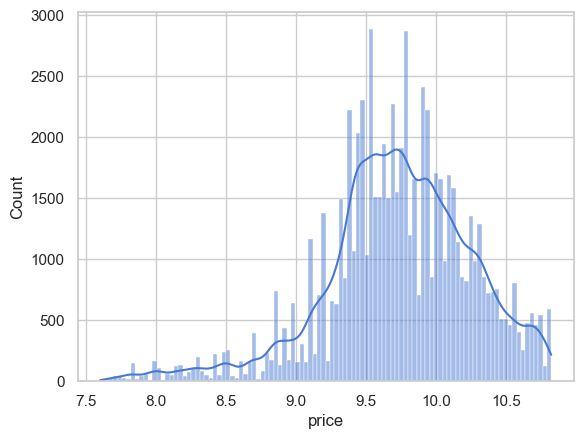

In [22]:
print('Con una transformación logarítmica:')
sns.histplot(np.log(train[target]), kde = True);

Aplicando box-cox:


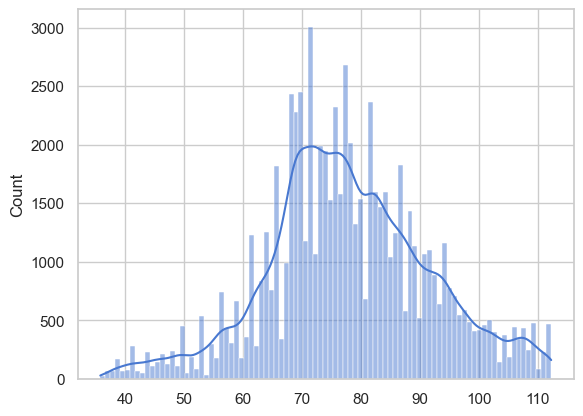

In [23]:
print('Aplicando box-cox:')
sns.histplot(stats.boxcox(train[target])[0], kde = True);

Ambas transformaciones acercan el target a la normalidad, pero vamos a utilizar un Q-Q plot para ver qué transformación nos conviene más.

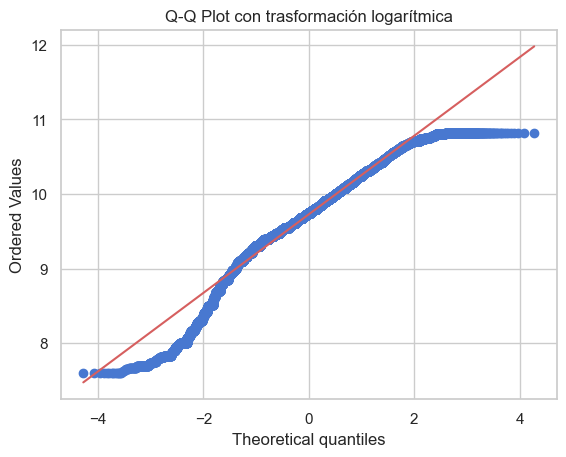

In [24]:
stats.probplot(np.log(train[target]), dist = "norm", plot = plt)
plt.title('Q-Q Plot con trasformación logarítmica')
plt.show();

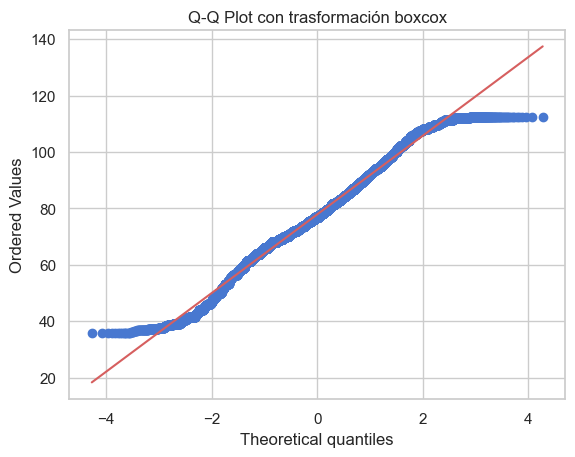

In [25]:
stats.probplot(stats.boxcox(train[target])[0], dist = "norm", plot = plt)
plt.title('Q-Q Plot con trasformación boxcox')
plt.show();

La transformación logarítmica hace que la distribución se desvíe en valores bajos, mientras que la boxcox lo hace con valores muy altos. Vamos a utilizar la transformación logarítmica principalmente por simplicidad.

## Preselección de variables

Vamos a eliminar aquellas variables cuyo % de nulos es muy alto y aquellas que hemos seleccionado al ver su descripción.

In [26]:
cols_to_drop = ['doors', 'color', 'description', 'vehicle_type', 'currency', 'dealer_name', 'dealer_description', \
                'dealer_address', 'dealer_city', 'dealer_country_code', 'dealer_is_professional', 'dealer_website', \
                'dealer_registered_at', 'date', 'publish_date', 'update_date', 'location', 'photos']

In [27]:
train.drop(columns = cols_to_drop, inplace = True)

In [28]:
print(f'Ahora tenemos {len(train.columns)} columnas')

Ahora tenemos 10 columnas


Como el dataset proviene de anuncios en diferentes aplicaciones, tenemos muchos duplicados en los que solo cambia la fecha de actualización, que ahora hemos eliminado. Por ello, vamos a limpiar ahora los duplicados.

In [29]:
print(f'El número de instancias originales es: {train.shape[0]}\n\
El número de instancias sin duplicar es: {train.drop_duplicates().shape[0]}')

El número de instancias originales es: 72388
El número de instancias sin duplicar es: 35660


In [30]:
train.drop_duplicates(keep = 'last', inplace = True)

## Análisis exploratorio de los datos: univariante

### Variables numéricas

In [31]:
num_cols = []
for col in train.columns:
    if col == 'price':
        pass
    elif train[col].dtype == 'int64' or train[col].dtype == 'float64':
        num_cols.append(col)
    
print('Las variables numéricas son:', num_cols)

Las variables numéricas son: ['year', 'kms', 'power', 'dealer_zip_code']


(4, 2)


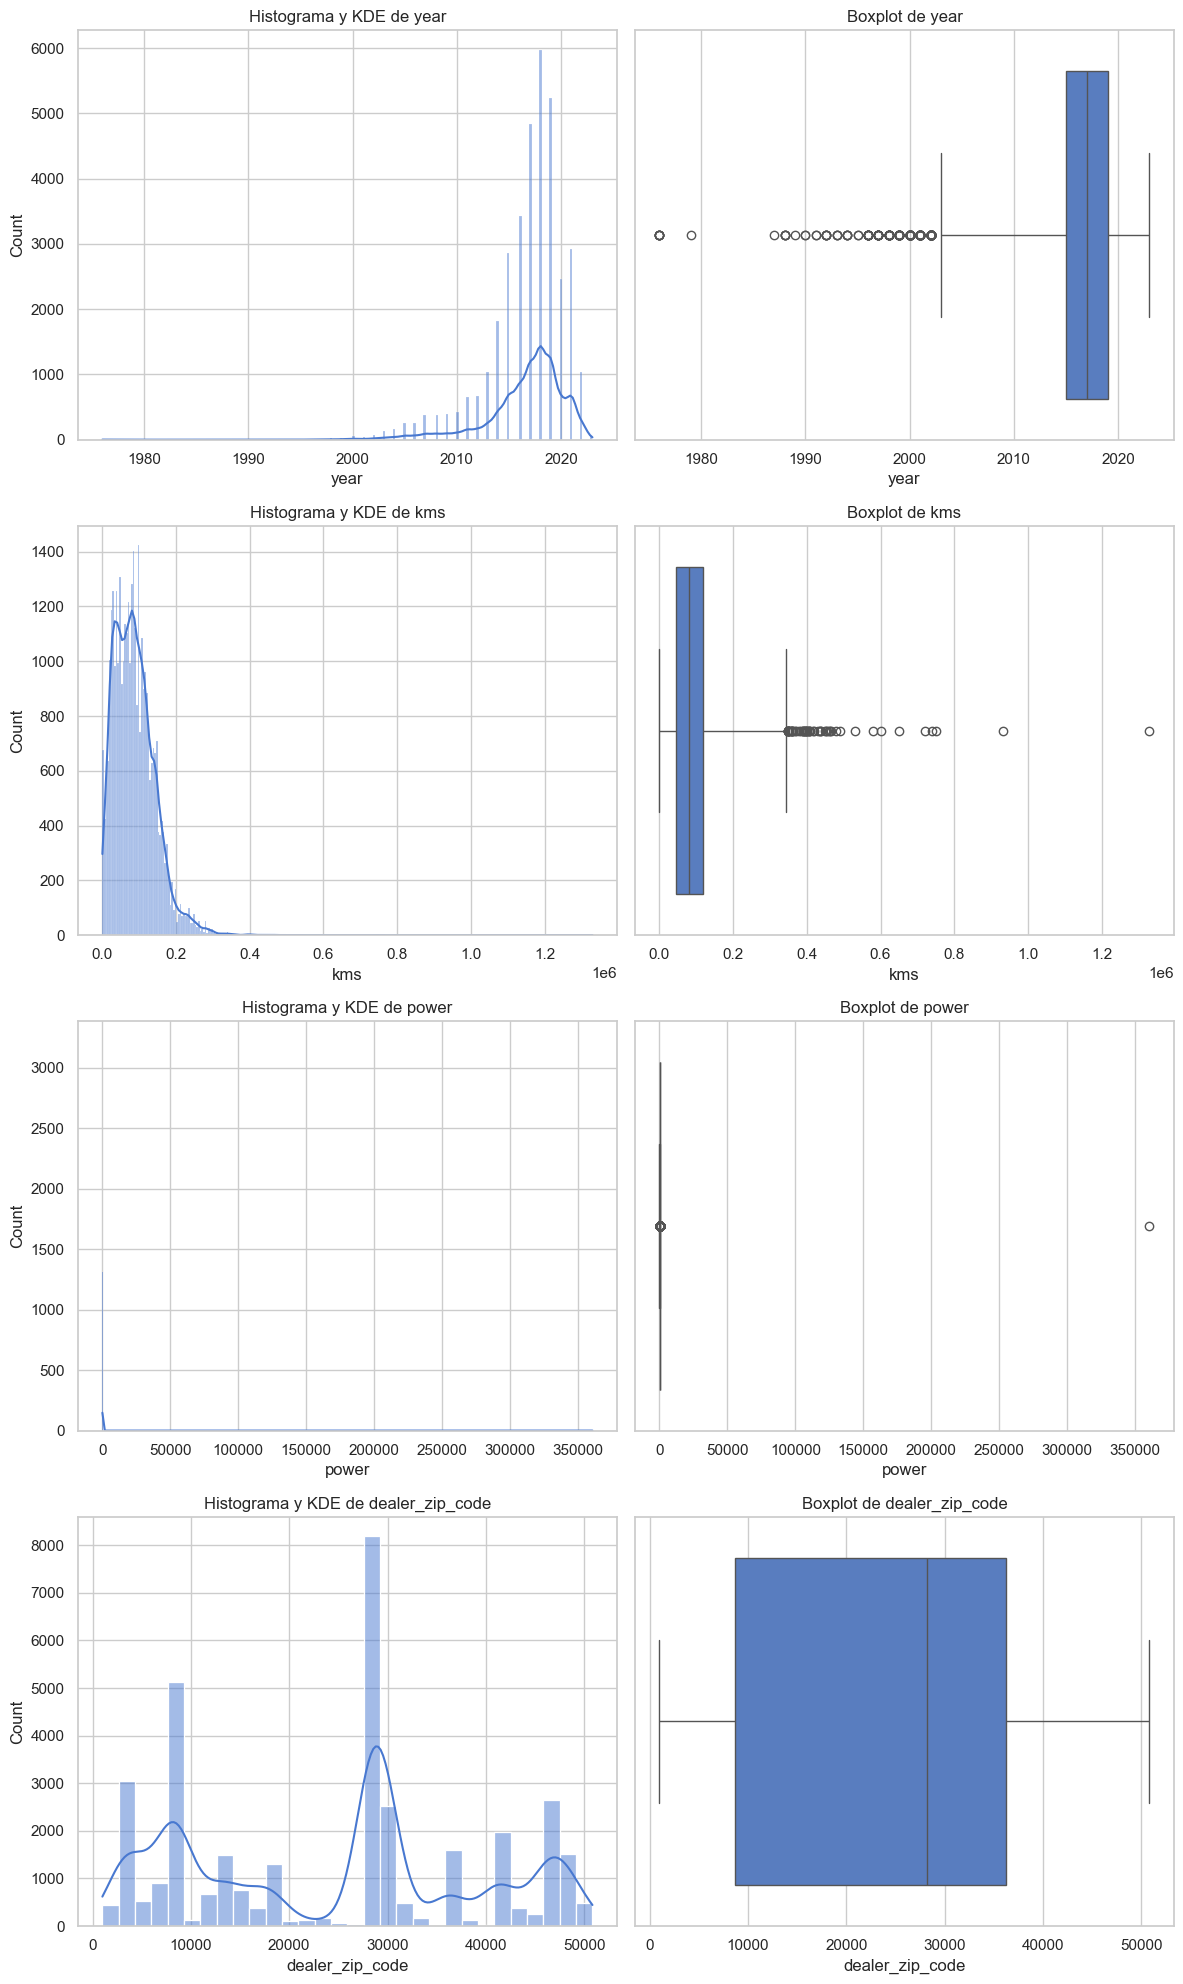

In [32]:
viz.plot_distribution_combined_graphs(train, num_cols, whisker_width = 3)

Analizando los histogramas de cada variable numérica, podemos observar lo siguiente:
- year: se puede observar que la mayor parte de los vehículos son posteriores al año 2000, su distribución es asimétrica, por lo que intentaremos normalizarla.
- kms: distribución asimétrica, la mayor parte de los valores se encuentran entre 0 y 250000 km, intentaremos normalizar.
- power: se observan valores muy altos para ser la potencia real de un vehículo, por lo que hay errores. Estudiaremos con mayor detenimiento esta columna.
- dealer_zip_code: el código postal se reparte algo más por todo el rango de valores, pero veremos qué tal le sienta la normalización.

In [33]:
train[num_cols].describe()

,year,kms,power,dealer_zip_code
count,35660.000000,3.547300e+04,35592.000000,35636.000000
mean,2016.624678,8.726165e+04,146.202152,24391.400073
std,3.903641,5.636462e+04,1911.364836,14607.075538
min,1976.000000,0.000000e+00,0.000000,1002.000000
25%,2015.000000,4.401700e+04,102.000000,8734.000000
50%,2017.000000,8.100000e+04,125.000000,28230.000000
75%,2019.000000,1.190880e+05,150.000000,36211.000000
max,2023.000000,1.330000e+06,360571.000000,50820.000000


#### Power

In [34]:
train.loc[train.power < train.power.max(), 'power'].max()

np.float64(740.0)

In [35]:
train.loc[train.power > 800]

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code
48803,Audi,S8,4.0 TFSI 571 quattro 4p tip.,Gasolina,2000,250000.0,360571.0,automatic,6000,2007.0


Vemos que el coche con 360571 caballos es un error, ya que no existe un vehículo con esa potencia. El resto sin embargo sí son correctos, por lo que solo vamos a eliminar aquellos anuncios con una potencia superior a los 1020 caballos, ya que hay un modelo de Tesla en el mercado que llega a esa potencia.

In [36]:
train.drop(train.loc[train.power > 1020].index, inplace = True)

### Variables categóricas

Como variables categóricas vamos a contar únicamente fuel y shift, ya que make, model y version tienen demasiadas categorías, por lo que veremos qué hacer con ellas más adelante.

In [37]:
cat_cols = ['fuel', 'shift']

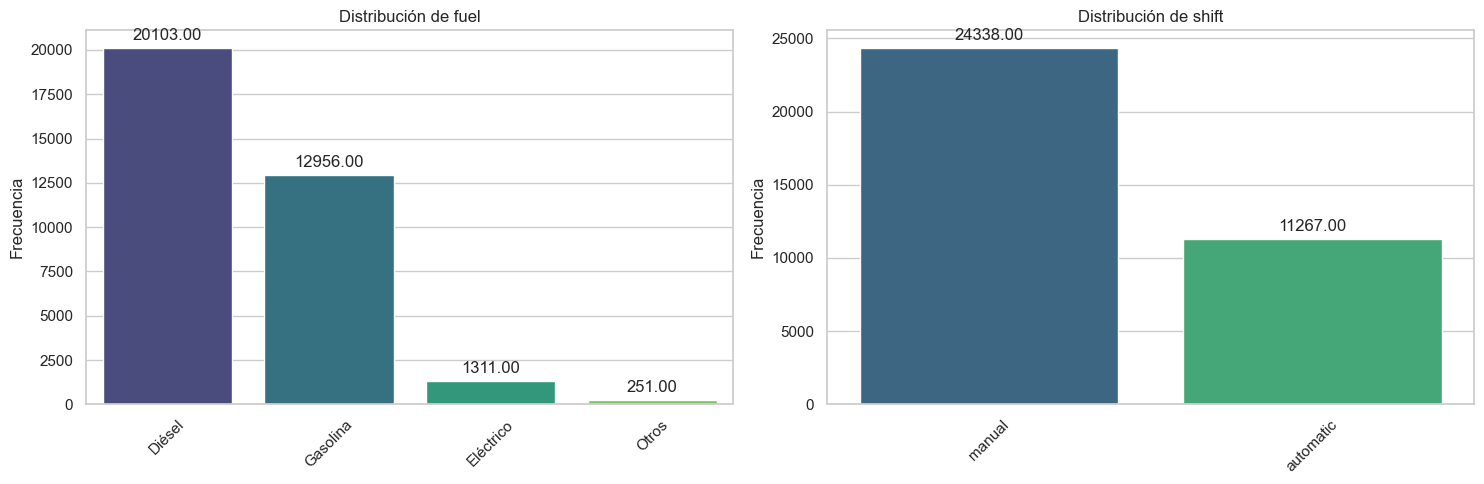

In [38]:
viz.plot_distribution_categoricas(train, cat_cols, relativa = False, mostrar_valores = True);

No observamos nada extraño, más adelante haremos un análisis bivariante para comparar las categorías con el target.

Como decíamos, las columnas de make, model y version, las valoraremos en la parte de ingeniería de datos, para ver qué podemos hacer con ellas y qué información extra podemos obtener.

## Análisis exploratorio de los datos: bivariante

### Variables numéricas contra target

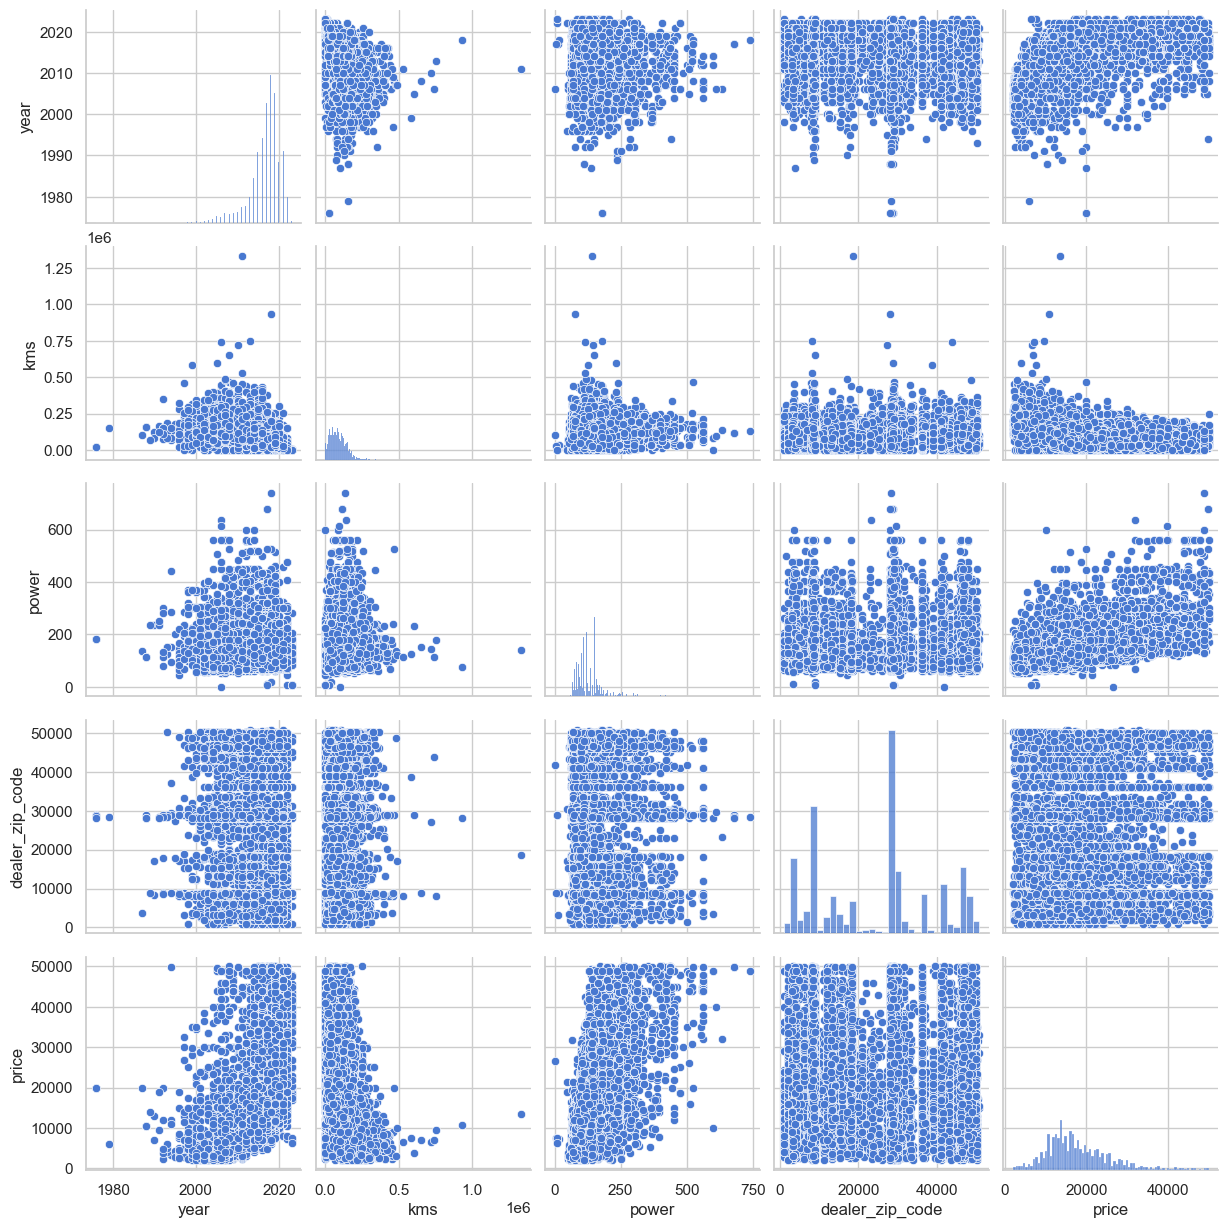

In [39]:
sns.pairplot(train[num_cols + [target]]);

Solamente podríamos relacionar algo la variable power con price, el resto no parece que tengan mucha relación con el precio del coche.

Vamos a ver la correlación que hay entre las variables numéricas seleccionadas y el target, para ver la importancia que pueden tener.

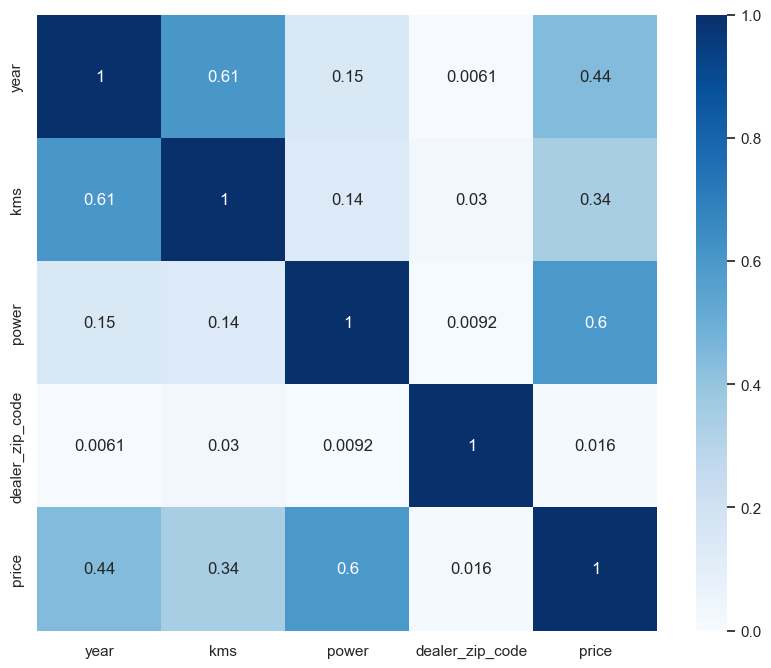

In [40]:
plt.figure(figsize = (10,8))
sns.heatmap(np.abs(train[num_cols + [target]].corr()), annot = True, cmap = 'Blues', vmin = 0, vmax = 1);

Observamos una fuerte correlación entre el target y power. Year y kms también tienen una correlación interesante, sin embargo dealer_zip_code no parece que aporten mucho. Haremos dos listas, una con todas las variables y otra con las que tienen algo de correlación.

In [41]:
num_feat = num_cols.copy()
num_feat_corr = ['power', 'kms', 'year']

### Variables categóricas contra target

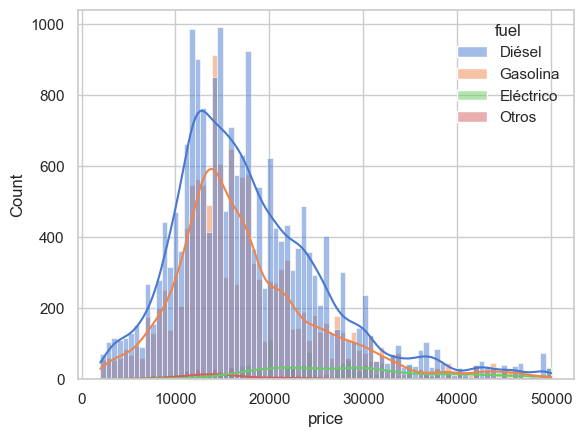

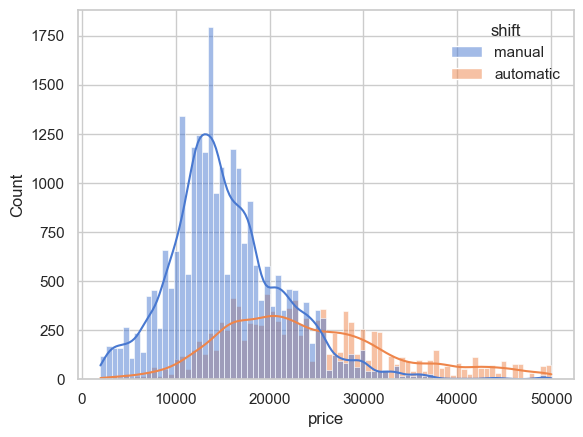

In [42]:
for col in cat_cols:
    sns.histplot(train.loc[train[target] < 100000], x = target, hue = col, kde = True)
    plt.show();

Tras analizar la relación entre target y categorías, podemos observar:
- Parece que los coches eléctricos tienen un precio mayor que los que se mueven con combustible fósil.
- Parece que los coches automáticos son más caros que los manuales.

Por ello, vamos a añadir ambas columnas a nuestras features finales.

In [43]:
cat_feat = cat_cols.copy()

Además, vamos a añadir de momento las columnas make y model a la selección de categóricas.

In [44]:
total_cat_feat = cat_feat + ['make', 'model']
total_cat_feat

['fuel', 'shift', 'make', 'model']

## Tratamiento de nulos

Vamos a ver cuántos nulos tiene nuestro dataset de train para ver si los eliminamos o intentamos introducir esos datos faltantes.

In [45]:
train.isna().sum() / len(train) * 100

make               0.000000
model              0.000000
version            0.137413
fuel               2.910906
year               0.000000
kms                0.524412
power              0.190695
shift              0.151434
price              0.000000
dealer_zip_code    0.067304
dtype: float64

Vemos que las siguientes columnas tienen nulos:
- version: no vamos a eliminarlos, porque es una columna que probablemente transformemos y eliminemos más adelante.
- fuel: tiene un 3% de nulos. Como la mayor parte de los vehículos son diésel o gasolina, probablemente utilicemos la moda para rellenar esos faltantes.
- kms: podemos utilizar la media o mediana para rellenarlos.
- power: podemos utilizar la media o mediana para rellenarlos también.
- shift: hay más coches manuales que automáticos, probablemente los rellenemos con la moda.
- dealer_zip_code: tiene muy pocos nulos, podemos utilizar la moda (es una numérica discreta) para rellenar esos nulos.

In [46]:
train.loc[train['fuel'].isna()]

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code
46160,Ford,Tourneo Custom,2.0 Ecoblue 96kW (130CV) Hybrid L1 Trend,NaN,2020,31649.0,130.0,manual,27990,23008.0
3132,Toyota,Corolla,1.8 125H BUSINESS E-CVT TOURING SPORT,NaN,2020,12429.0,122.0,automatic,20990,3010.0
808,Renault,Arkana,RS Line TCe 103kW(140CV) EDC MicroH.-SS,NaN,2021,19995.0,140.0,automatic,27490,41005.0
81746,Toyota,C-HR,1.8 125H Dynamic Plus,NaN,2017,55586.0,122.0,automatic,20990,36211.0
66277,Toyota,C-HR,1.8 125H Advance,NaN,2021,47306.0,122.0,automatic,22990,17007.0
...,...,...,...,...,...,...,...,...,...,...
69479,Opel,Corsa,1.4 100 Selective 3p,NaN,2012,100000.0,100.0,manual,6800,43202.0
48555,CUPRA,Leon,1.4 e-Hybrid 180kW (245CV) DSG,NaN,2020,36000.0,245.0,automatic,32990,36211.0
56886,CUPRA,Leon,1.4 e-Hybrid 180kW (245CV) DSG,NaN,2020,36000.0,245.0,automatic,32990,48004.0
5311,Citroen,C5 X,Hybrid 225 e-EAT8 Shine,NaN,2022,2.0,225.0,automatic,40950,8830.0


En la columna version de los coches que no tienen fuel, podemos obtener información de si es gasolina/diesel o hibrido/eléctrico, por lo que no tocaremos esta columna hasta que hayamos transformado version. Lo mismo ocurre con power. 

Sin embargo, kms, shift y dealer_zip_code sí podemos rellenarlas.

In [93]:
kms_mean_train = train['kms'].mean().round(0)
shift_mode_train = train['shift'].mode()[0]
dealer_zip_code_mode_train = train['dealer_zip_code'].mode()[0]

train.loc[train['kms'].isna(), 'kms'] = kms_mean_train
train.loc[train['shift'].isna(), 'shift'] = shift_mode_train
train.loc[train['dealer_zip_code'].isna(), 'dealer_zip_code'] = dealer_zip_code_mode_train

## Modificación de ciertas variables

Vamos a intentar sacar toda la información posible de la columna version que sea común a todos los coches. También limpiaremos make y model, quitando espacios innecesarios y convirtiendo en minúsculas cada string. Para ello, vamos a crear diferentes funciones que nos ayuden a realizar esta tarea.

In [48]:
def extract_info(x):
    if not isinstance(x, str):
        return pd.Series([0, 0, 0])
    
    pattern = r'(?P<number>\b\d\.\d\b)[dD]?|(?P<kw>\d+)\s*kW|(?P<cv>\d+)\s*CV'
    matches = re.findall(pattern, x, re.IGNORECASE)

    cylinders_capacity = kw = cv = 0
    for match in matches:
        if match[0]:
            cylinders_capacity = float(match[0])
        if match[1]:
            kw = float(match[1])
        if match[2]:
            cv = float(match[2])
    
    return pd.Series([cylinders_capacity, kw, cv])

def lowercase_info(x):
    return x.lower().strip()

In [49]:
train[['cylinders_capacity', 'kW', 'CV']] = train['version'].apply(extract_info)
train['make'] = train['make'].apply(lowercase_info)
train['model'] = train['model'].apply(lowercase_info)

In [50]:
train.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code,cylinders_capacity,kW,CV
86979,citroen,c5,2.0 HDi 140cv Business,Diésel,2015,133690.0,140.0,manual,10290,28021.0,2.0,0.0,140.0
74932,fiat,500l,Pop Star 1.4 16v 95CV,Gasolina,2015,165699.0,95.0,manual,7990,46070.0,1.4,0.0,95.0
76079,volkswagen,polo,Advance 1.0 TSI 70kW (95CV),Gasolina,2021,56215.0,95.0,manual,16490,28021.0,1.0,70.0,95.0
98989,citroen,c4 picasso,BlueHDi 120cv EAT6 Live Edition,Diésel,2016,128108.0,120.0,automatic,12990,18005.0,0.0,0.0,120.0
21915,fiat,500,1.2 51 kW (69 CV) S Dualogic,Gasolina,2017,95000.0,69.0,automatic,10900,11140.0,1.2,51.0,69.0


#### Power

In [51]:
train.loc[train['power'].isna(), 'power'] = train.loc[train['power'].isna(), 'CV']

In [52]:
train.loc[train['power'] < 1]

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code,cylinders_capacity,kW,CV
51219,peugeot,107,1.0i Urban,Gasolina,2010,199000.0,0.0,manual,4990,8028.0,0.0,0.0,0.0
1088,renault,clio,Confort Dynamique 1.4 16v,Gasolina,2006,113000.0,0.0,manual,4990,8028.0,1.4,0.0,0.0
58290,mercedes-benz,clase s,280S,Gasolina,1979,151862.0,0.0,manual,6000,28294.0,0.0,0.0,0.0
90556,citroen,c3,C3 1.4 COOL,Gasolina,2009,61416.0,0.0,manual,6990,46600.0,1.4,0.0,0.0
45742,mercedes-benz,clase e,300D (W123),NaN,1995,87257.0,0.0,manual,4200,27297.0,0.0,0.0,0.0
99326,citroen,c4 picasso,Grand Picasso 2.0HDI Exclusive+ CMP,Diésel,2008,184000.0,0.0,automatic,5999,8520.0,0.0,0.0,0.0
34644,toyota,mr2,2.0 16v,NaN,1990,81000.0,0.0,manual,13000,8420.0,2.0,0.0,0.0
94214,citroen,berlingo,M BHdi 130 S&S Feel Pack,Diésel,2022,2.0,0.0,manual,29490,48950.0,0.0,0.0,0.0
91859,citroen,c3,YOU,Gasolina,2022,18300.0,0.0,manual,12495,8860.0,0.0,0.0,0.0
59958,ford,transit custom,Kombi 2.0 TDCI 96kW 310 L2 Ambiente,Diésel,2018,146257.0,0.0,manual,18900,29006.0,2.0,96.0,0.0


Ahora los nulos se han transformado en 0.0, pero aún podemos obtener alguna potencia más de algún coche utilizando los kW. Vamos a utilizar el kW en aquellos que podamos y al resto le aplicaremos la media redondeada.

In [53]:
train.loc[train['power'] == 0, 'power'] = train.loc[train['power'] == 0, 'kW']

power_mean_train = train['power'].mean().round(0)
train.loc[train['power'] == 0, 'power'] = power_mean_train

La columna de power ya no tiene ningún valor nulo.

#### Fuel y version

La columna version vamos a dejarla con nulos, ya que no la vamos a utilizar para entrenar a nuestro modelo. Sin embargo, no hemos conseguido información sobre el tipo de combustible que utilizan los vehículos al descomponer la columna de version. Por ello, vamos a utilizar la moda para rellenar los nulos que hay en fuel.

In [54]:
fuel_mode_train = train['fuel'].mode()[0]
train.loc[train['fuel'].isna(), 'fuel'] = fuel_mode_train

Además, vamos a eliminar las columnas de kW y CV, ya que no las vamos a utilizar más.

In [55]:
train.drop(columns = ['kW', 'CV'], inplace = True)

### Nuevas variables

#### power_cat
Como ya tenemos la potencia de todos los vehículos, podemos clasificarlos según su potencia.

In [56]:
def clasificar_potencia(power):
    if power < 100:
        return 'Baja'
    elif power < 150:
        return 'Media'
    elif power < 200:
        return 'Alta'
    else:
        return 'Muy Alta'

In [57]:
train['power_cat'] = train['power'].apply(clasificar_potencia)

#### Ratio kms_years

Podemos establecer más o menos el desgaste del vehículo dividiendo el kilometraje del coche entre los años que tiene desde su matriculación. Los datos están actualizados hasta el 2023, por lo que vamos a utilizar el 2024 como guía.

In [58]:
actual_year = 2024

train['kms_years'] = train.apply(lambda row: row['kms'] / (actual_year - row['year']), axis = 1)

#### Etiqueta medioambiental

En el mercado de segunda mano de coches en España, una variable muy importante es la etiqueta medioambiental del coche, ya que según esta misma, el coche puede acceder o no a diferentes ciudades o zonas. Esta etiqueta depende del año de matriculación y del tipo de combustible, siendo:
- A (sin etiqueta): gasolina anteriores a 2001 y diésel anteriores a 2006
- B: gasolina de 2001 a 2006 y diésel de 2006 a 2015
- C: gasolina a partir de 2006 y diésel a partir de 2015
- ECO: coches híbridos
- ZERO: coches eléctricos

In [59]:
filter_A = ((train['year'] < 2001) & (train['fuel'] == 'Gasolina')) | ((train['year'] < 2006) & (train['fuel'] == 'Diésel'))
filter_B = ((train['year'] >= 2001) & (train['year'] < 2006) & (train['fuel'] == 'Gasolina')) | ((train['year'] >= 2006) & (train['year'] < 2015) & (train['fuel'] == 'Diésel'))
filter_C = ((train['year'] >= 2006) & (train['fuel'] == 'Gasolina')) | ((train['year'] >= 2015) & (train['fuel'] == 'Diésel'))
filter_ZERO = (train['fuel'] == 'Eléctrico')
filter_otros = train['fuel'] == 'Otros'

In [60]:
train.loc[filter_A, 'emission_label'] = 'A'
train.loc[filter_B, 'emission_label'] = 'B'
train.loc[filter_C, 'emission_label'] = 'C'
train.loc[filter_ZERO, 'emission_label'] = 'ZERO'
train.loc[filter_otros, 'emission_label'] = train['emission_label'].mode()[0]

In [61]:
train.emission_label.value_counts()

emission_label
C       29068
B        4745
ZERO     1311
A         535
Name: count, dtype: int64

Observamos que la mayor parte de coches tienen etiqueta C. Valoraremos más adelante si puede ser una variable interesante.

In [62]:
train.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_zip_code,cylinders_capacity,power_cat,kms_years,emission_label
86979,citroen,c5,2.0 HDi 140cv Business,Diésel,2015,133690.0,140.0,manual,10290,28021.0,2.0,Media,14854.444444,C
74932,fiat,500l,Pop Star 1.4 16v 95CV,Gasolina,2015,165699.0,95.0,manual,7990,46070.0,1.4,Baja,18411.000000,C
76079,volkswagen,polo,Advance 1.0 TSI 70kW (95CV),Gasolina,2021,56215.0,95.0,manual,16490,28021.0,1.0,Baja,18738.333333,C
98989,citroen,c4 picasso,BlueHDi 120cv EAT6 Live Edition,Diésel,2016,128108.0,120.0,automatic,12990,18005.0,0.0,Media,16013.500000,C
21915,fiat,500,1.2 51 kW (69 CV) S Dualogic,Gasolina,2017,95000.0,69.0,automatic,10900,11140.0,1.2,Baja,13571.428571,C


## Análisis exploratorio de las nuevas variables

Procedemos a ver qué información nos dan las nuevas variables obtenidas a partir de las columnas existentes desde un inicio.

### Variables numéricas

In [63]:
new_num_cols = ['cylinders_capacity', 'kms_years']

(2, 2)


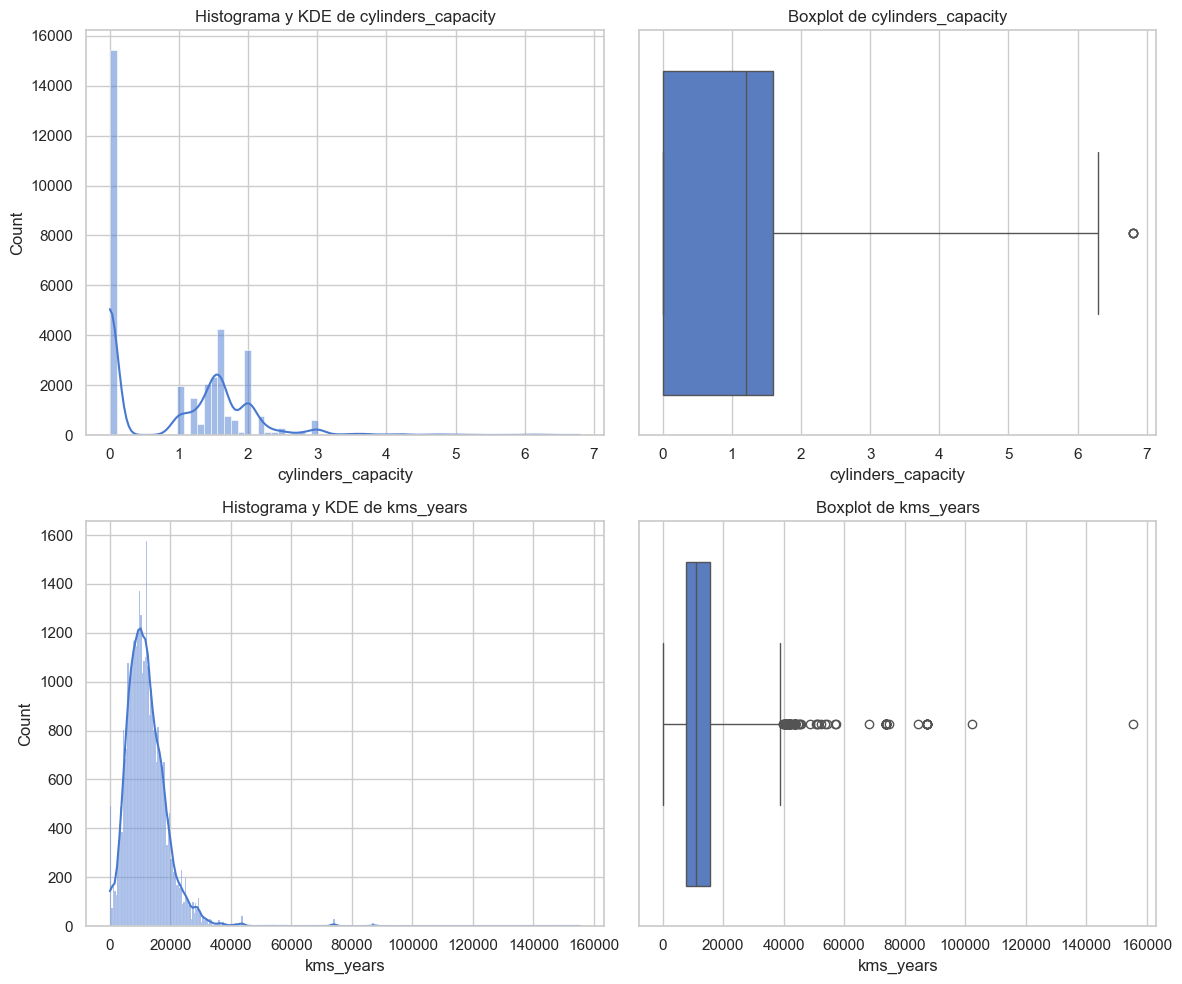

In [64]:
viz.plot_distribution_combined_graphs(train, new_num_cols, whisker_width = 3)

Podemos observar:
- En cylinders_capacity hay dos categorías principales: 0 que indica que no conocemos la cilindrada y >0 que sí la conocemos, tendremos que tenerlo en cuenta.
- La relación kms_years tiene varios outliers que tendremos que tratar en caso de malos resultados con nuestro modelo.

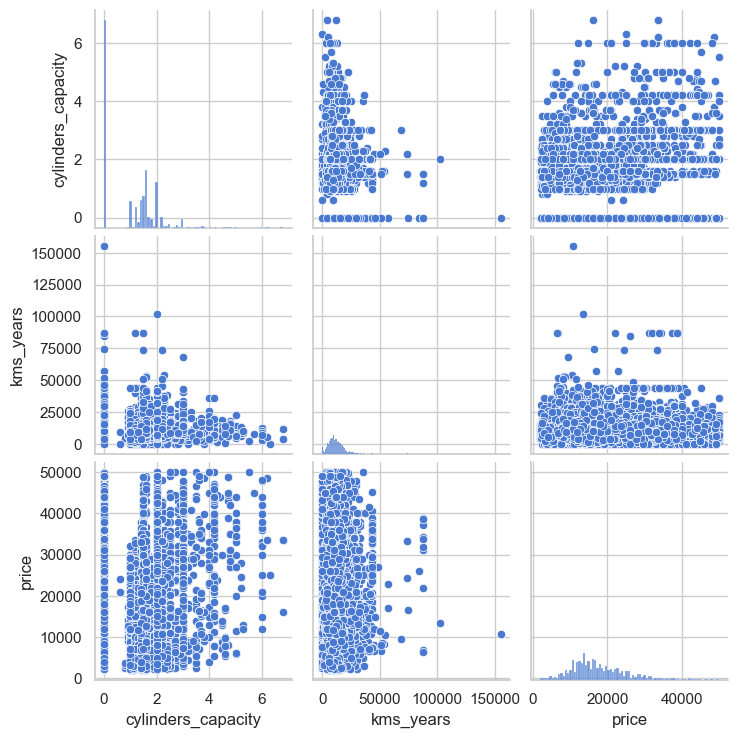

In [65]:
sns.pairplot(train[new_num_cols + [target]]);

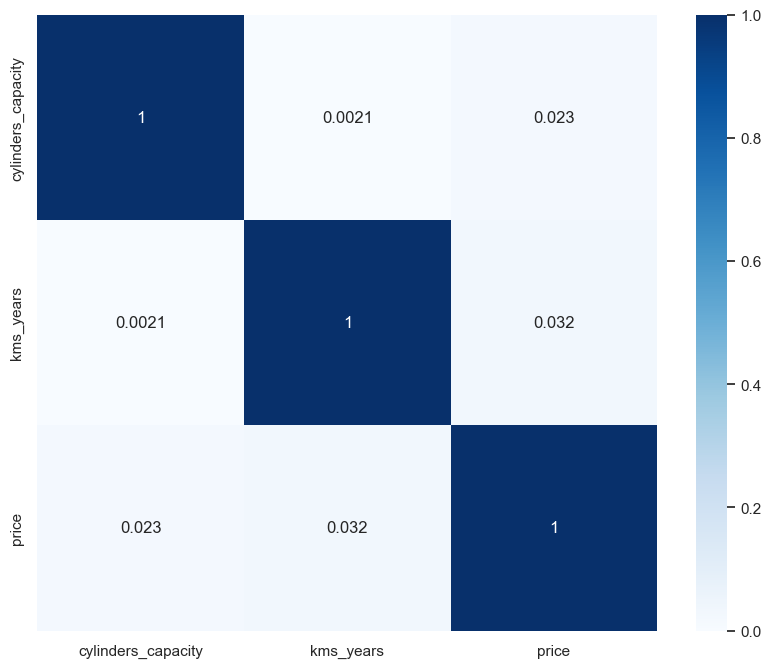

In [66]:
plt.figure(figsize = (10,8))
sns.heatmap(np.abs(train[new_num_cols + [target]].corr()), annot = True, cmap = 'Blues', vmin = 0, vmax = 1);

Visualizando la relación entre estas nuevas variables y el precio, no encontramos demasiada correlación. Por ello, añadiremos únicamente kms_years a la selección de correlación y las dos a la selección general.

In [67]:
num_feat.append('cylinders_capacity')
num_feat.append('kms_years')
num_feat_corr.append('kms_years')

### Variables categóricas

In [68]:
new_cat_cols = ['power_cat', 'emission_label']

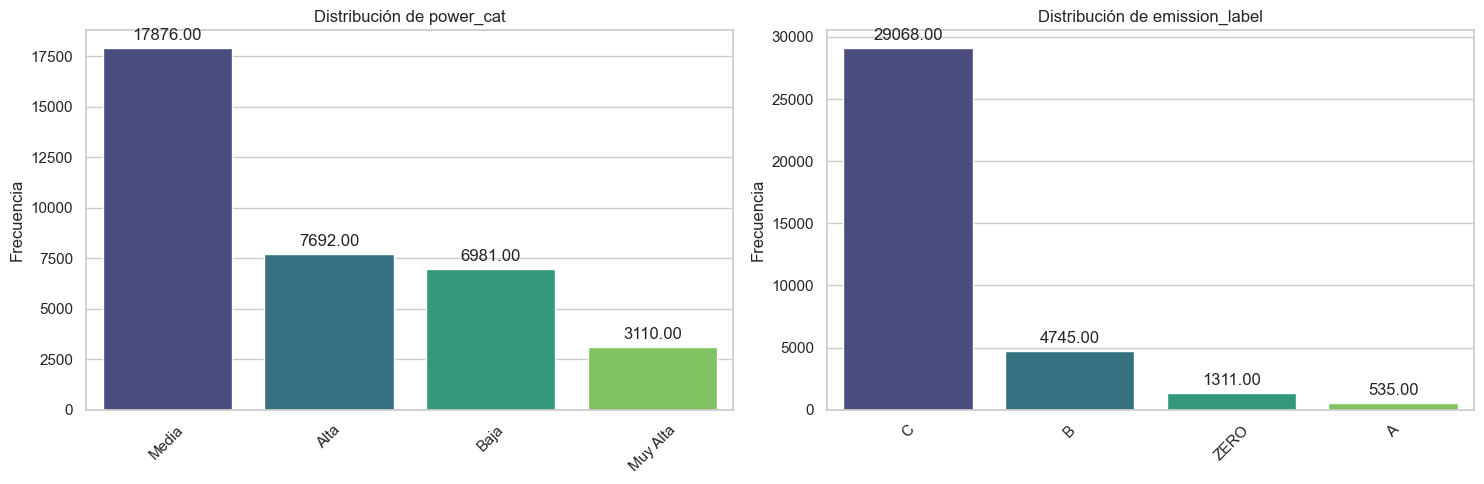

In [69]:
viz.plot_distribution_categoricas(train, new_cat_cols, relativa = False, mostrar_valores = True);

Observamos lo siguiente:
- La mayor parte de los vehículos tienen una potencia media, es decir, entre 100 y 150 caballos.
- La mayor parte de los vehículos tienen etiqueta C.

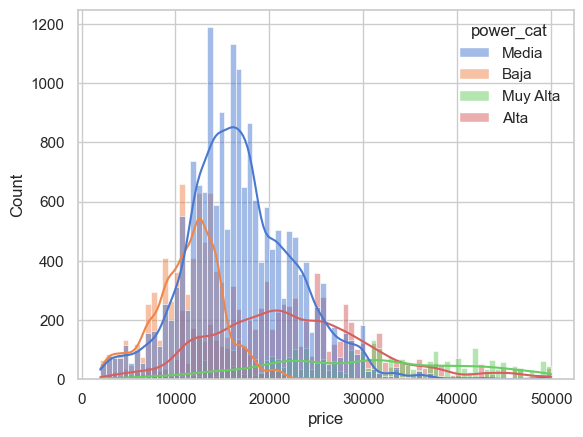

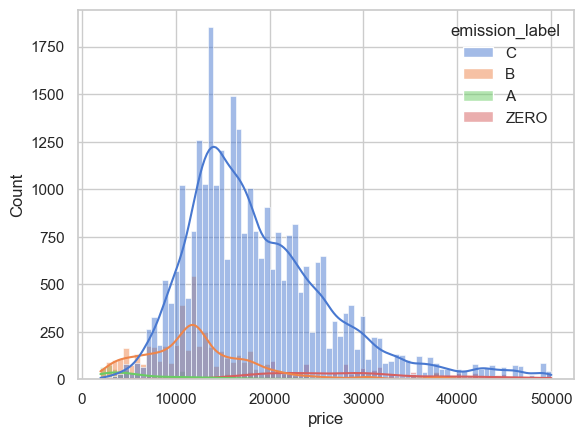

In [70]:
for col in new_cat_cols:
    sns.histplot(train.loc[train[target] < 100000], x = target, hue = col, kde = True)
    plt.show();

La categorización según potencia sí distingue en precios y parece que la etiqueta medioambiental también tiene importancia, por lo que incluiremos ambas.

In [71]:
total_cat_feat.append('power_cat')
total_cat_feat.append('emission_label')

## Transformación de datos de test

A continuación, vamos a realizar estas mismas transformaciones al dataset de test.

In [ ]:
# Eliminamos las columnas que no nos interesan:
test.drop(columns = cols_to_drop, inplace = True)

# Eliminamos aquellos vehículos que tengan un valor menor de 2000, ya que serán despieces o anuncios falsos:
test.drop(index = (test.loc[test[target] < 2000].index), inplace = True)

# Eliminamos los duplicados:
test.drop_duplicates(keep = 'last', inplace = True)

# Eliminamos aquellas columnas que tengan una potencia superiora 1020, puesto que son un error:
test.drop(test.loc[test.power > 1020].index, inplace = True)

# Rellenamos los nulos con la media y modas que hemos utilizado de train:
test.loc[test['kms'].isna(), 'kms'] = kms_mean_train
test.loc[test['shift'].isna(), 'shift'] = shift_mode_train
test.loc[test['dealer_zip_code'].isna(), 'dealer_zip_code'] = dealer_zip_code_mode_train

# Obtenemos toda la información posible de la columna de version y limpiamos make y model:
test[['cylinders_capacity', 'kW', 'CV']] = test['version'].apply(extract_info)
test['make'] = test['make'].apply(lowercase_info)
test['model'] = test['model'].apply(lowercase_info)

# Rellenamos los faltantes de power que podemos utilizando la información obtenida de version:
test.loc[test['power'].isna(), 'power'] = test.loc[test['power'].isna(), 'CV']
test.loc[test['power'] == 0, 'power'] = test.loc[test['power'] == 0, 'kW']
test.loc[test['power'] == 0, 'power'] = power_mean_train

# Rellenamos los nulos con la moda de fuel de train:
test.loc[test['fuel'].isna(), 'fuel'] = fuel_mode_train

# Eliminamos kW y CV:
test.drop(columns = ['kW', 'CV'], inplace = True)

# Creamos las variables de power_cat y kms_years:
test['power_cat'] = test['power'].apply(clasificar_potencia)
test['kms_years'] = test.apply(lambda row: row['kms'] / (actual_year - row['year']), axis = 1)

# Creamos la variable de emission_label:
filter_A_test = ((test['year'] < 2001) & (test['fuel'] == 'Gasolina')) | ((test['year'] < 2006) & (test['fuel'] == 'Diésel'))
filter_B_test = ((test['year'] >= 2001) & (test['year'] < 2006) & (test['fuel'] == 'Gasolina')) | ((test['year'] >= 2006) & (test['year'] < 2015) & (test['fuel'] == 'Diésel'))
filter_C_test = ((test['year'] >= 2006) & (test['fuel'] == 'Gasolina')) | ((test['year'] >= 2015) & (test['fuel'] == 'Diésel'))
filter_ZERO_test = (test['fuel'] == 'Eléctrico')
filter_otros_test = test['fuel'] == 'Otros'
test.loc[filter_A_test, 'emission_label'] = 'A'
test.loc[filter_B_test, 'emission_label'] = 'B'
test.loc[filter_C_test, 'emission_label'] = 'C'
test.loc[filter_ZERO_test, 'emission_label'] = 'ZERO'
test.loc[filter_otros_test, 'emission_label'] = train['emission_label'].mode()[0]

In [73]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14495 entries, 75721 to 42410
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   make                14495 non-null  object 
 1   model               14495 non-null  object 
 2   version             14471 non-null  object 
 3   fuel                14495 non-null  object 
 4   year                14495 non-null  int64  
 5   kms                 14495 non-null  float64
 6   power               14495 non-null  float64
 7   shift               14495 non-null  object 
 8   price               14495 non-null  int64  
 9   dealer_zip_code     14495 non-null  float64
 10  cylinders_capacity  14495 non-null  float64
 11  power_cat           14495 non-null  object 
 12  kms_years           14495 non-null  float64
 13  emission_label      14495 non-null  object 
dtypes: float64(5), int64(2), object(7)
memory usage: 1.7+ MB


Ya tenemos tanto train como test transformados inicialmente. Ahora vamos a preparar todos esos datos para entrenar a nuestros modelos de regresión.

## División en X_train, y_train y X_test, y_test

Dividimos ya los datasets de train y test para poder trabajarlos y meterlos en el modelo.

In [74]:
X_train = train.drop(columns = [target, 'version'])
y_train = train[target]

X_test = test.drop(columns = [target, 'version'])
y_test = test[target]

## Preparación de variables

### Numéricas

Primero, vamos a transformar las variables mediante un log para ver si así normalizamos su distribución. Y a continuación, procedemos a escalar todas las numéricas con MinMaxScaler, para que todos los valores se encuentren entre 0 y 1 (igual que el OneHotEncoder). El escalado lo realizamos porque más adelante utilizaremos un modelo de regresión lineal.

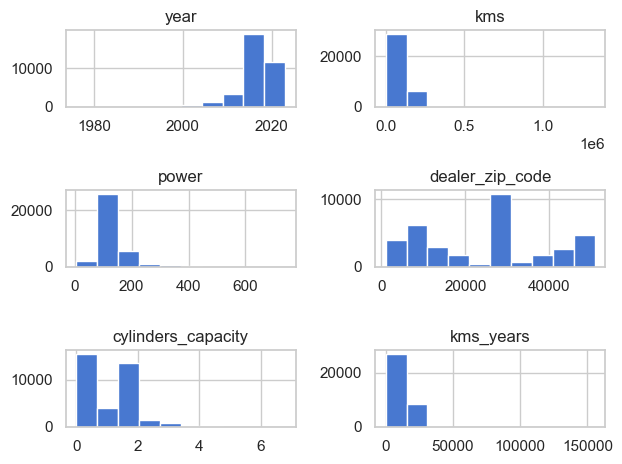

In [75]:
X_train[num_feat].hist()
plt.tight_layout()

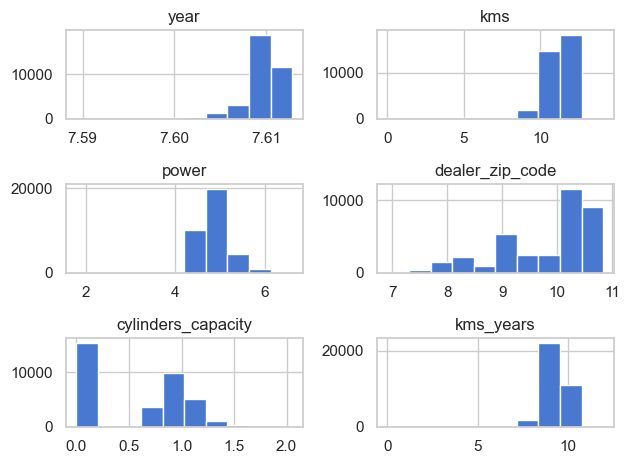

In [76]:
X_train[num_feat].apply(np.log1p).hist()
plt.tight_layout();

Exceptuando year y photos, vamos a transformar el resto de variables.

In [77]:
cols_to_log = num_feat.copy()
cols_to_log.remove('year')

In [78]:
total_cat_feat

['fuel', 'shift', 'make', 'model', 'power_cat', 'emission_label']

In [79]:
cols_to_log

['kms', 'power', 'dealer_zip_code', 'cylinders_capacity', 'kms_years']

In [80]:
log_transformer = FunctionTransformer(func = np.log1p)

num_pipeline = Pipeline([
    ("log", log_transformer)])

### Categóricas

Vamos a utilizar el One Hot Encoder de ScikitLearn para transformar las variables categóricas y las variables de make y model. Más adelante valoraremos utilizarlo con las de version.

In [81]:
cat_pipeline = Pipeline([
    ("ohencoder", OneHotEncoder(handle_unknown = "ignore"))])

### Preprocesado completo

In [82]:
preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, total_cat_feat),
        ("log", num_pipeline, cols_to_log)],
        remainder = "passthrough")

In [83]:
preprocessing.fit(X_train)

c:\Users\mpuch\Desktop\Portfolio_M_Puchades\ML_car_prices\env\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('ohencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['fuel', 'shift', 'make', 'model', 'power_cat',
                                  'emission_label']),
                                ('log',
                                 Pipeline(steps=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>))]),
                                 ['kms', 'power', 'dealer_zip_code',
                                  'cylinders_capacity', 'kms_years'])])

In [84]:
joblib.dump(preprocessing, '../../preprocessor.joblib', compress = True)

['../../preprocessor.joblib']

In [85]:
X_train = preprocessing.transform(X_train)
print('Las dimensiones finales de X_train son:', X_train.shape)

Las dimensiones finales de X_train son: (35659, 743)


#### Aplicamos las mismas transformaciones a X_test

In [86]:
X_test = preprocessing.transform(X_test)
print('Las dimensiones finales de X_test son:', X_test.shape)

Las dimensiones finales de X_test son: (14495, 743)


## Entrenamiento del modelo

Tras realizar diferentes pruebas en otros notebooks, decidimos:
- Utilizar un RandomForestRegressor.
- No transformar el target, ya que no mejora el error.
- Utilizar las siguientes columnas como features: ['make', 'model', 'fuel', 'year', 'kms', 'power', 'shift',
       'photos', 'price', 'dealer_zip_code', 'cylinders_capacity', 'power_cat',
       'kms_years', 'emission_label']
- No escalar las variables, puesto que no es necesario al ser un modelo basado en árboles de decisión.

In [87]:
rf_reg = RandomForestRegressor(n_estimators = 200,
                               min_samples_split = 2,
                               min_samples_leaf = 1,
                               max_features = 'sqrt',
                               max_depth = None,
                               bootstrap = False,
                               random_state = 42)

rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=200,
                      random_state=42)

## Evaluación contra Test

Vamos a probar nuestro modelo entrenado y optimizado contra test.

In [88]:
y_pred = rf_reg.predict(X_test)

In [89]:
print('ERROR CONTRA TEST')
print('-----------------')
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

ERROR CONTRA TEST
-----------------
RMSE: 744.6450620710344
R2: 0.9932831088356707


Guardamos el modelo

In [90]:
joblib.dump(rf_reg, '../../car_price_model.joblib', compress = True)

['../../car_price_model.joblib']

## Análisis del error de nuestro modelo

Comparamos en una gráfica los valores predichos y los reales.

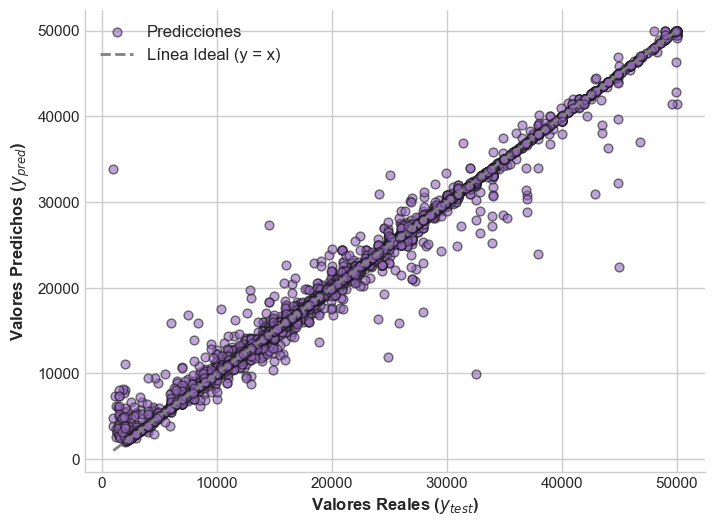

In [91]:
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha = 0.6, color = '#9467bd', edgecolors = 'k', s = 40, label = 'Predicciones')  

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'gray', linestyle = '--', linewidth = 2, label = 'Línea Ideal (y = x)')

plt.xlabel('Valores Reales ($y_{test}$)', fontsize=12, fontweight='bold')
plt.ylabel('Valores Predichos ($y_{pred}$)', fontsize=12, fontweight='bold')

plt.legend(frameon = False, fontsize = 12, loc = 'upper left')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Mostramos el residuo, es decir, la diferencia entre nuestros predicciones y el valor real.

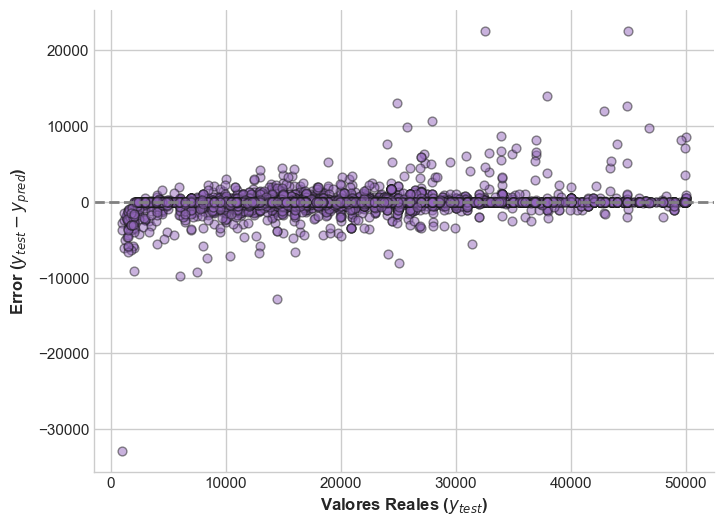

In [92]:
plt.figure(figsize = (8, 6))

plt.scatter(y_test, y_test - y_pred, alpha = 0.5, color = '#9467bd', edgecolors = 'k', s = 40)

plt.axhline(y = 0, color = 'gray', linestyle = '--', linewidth = 2)

plt.xlabel('Valores Reales ($y_{test}$)', fontsize = 12, fontweight = 'bold')
plt.ylabel('Error ($y_{test} - y_{pred}$)', fontsize = 12, fontweight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Como podemos observar en ambas gráficas, hay errores a tener en cuenta desde precios muy bajos hasta precios de 50000€. Esto podría mejorarse entrenando un modelo específico para coches de gama baja, segmentando la predicción según la categoría del vehículo.

También sería interesante valorar aquellos errores que superan los 10000€, para ver qué tipo de vehículos o qué datos pueden estar generando esa confusión. 

## Conclusiones

El error contra test de nuestro modelo optimizado cumple expectativas. 

Sin embargo, sería interesante proponer diferentes modelos según la gama del vehículo o del tipo de vehículo. Para ello sería necesario tener más datos, por ejemplo, solicitando en los anuncios más información sobre el coche. De esta manera, conseguiríamos un acercamiento mayor al precio justo en el momento actual del mercado automovilístico.

                                                                                    | Mariano Puchades del Olmo |                                                                                            